In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *
import random 

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()

In [8]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print(np.mean(y_te))


0.0946078431372549
0.0946078431372549
0.09456148946594807


In [7]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
random.seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data_tr, data_vl, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=30, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, identities_weight=0.2, identitity_weight_decay=0.98, one_onto=True)

head params 3283
embs params 1430
train epoch 00/30 | batch 013/192 | loss 2.4674 | elapsed 0.09s

train epoch 00/30 | batch 193/192 | loss 2.4657 | val loss 0.7433 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.5023 | pr auc 0.1075 | elapsed 1.52s
train epoch 01/30 | batch 193/192 | loss 1.4475 | val loss 0.2271 | acc 0.9529 | f1 0.7091 | prec 0.8540 | recall 0.6062 | roc auc 0.8811 | pr auc 0.7476 | elapsed 2.86s
train epoch 02/30 | batch 193/192 | loss 0.7169 | val loss 0.1845 | acc 0.9490 | f1 0.7234 | prec 0.7432 | recall 0.7047 | roc auc 0.9227 | pr auc 0.7939 | elapsed 2.72s
train epoch 03/30 | batch 193/192 | loss 0.5120 | val loss 0.1766 | acc 0.9407 | f1 0.6952 | prec 0.6765 | recall 0.7150 | roc auc 0.9250 | pr auc 0.7903 | elapsed 2.68s
train epoch 04/30 | batch 193/192 | loss 0.3873 | val loss 0.1715 | acc 0.9368 | f1 0.6892 | prec 0.6441 | recall 0.7409 | roc auc 0.9276 | pr auc 0.7950 | elapsed 2.75s
train epoch 05/30 | batch 193/192 | loss 0.2678 | val loss 0.1890 | acc 0.9333 | f1 0.6837 | prec 0.6203 | recall 0.7617 | roc auc 0.9251 | pr auc 0.7

             mean  std     micro
acc      0.963743  NaN  0.963743
prec     0.769231  NaN  0.769231
recall   0.880829  NaN  0.880829
f1       0.821256  NaN  0.821256
auc_roc  0.984980  NaN  0.984980
auc_pr   0.928413  NaN  0.928413


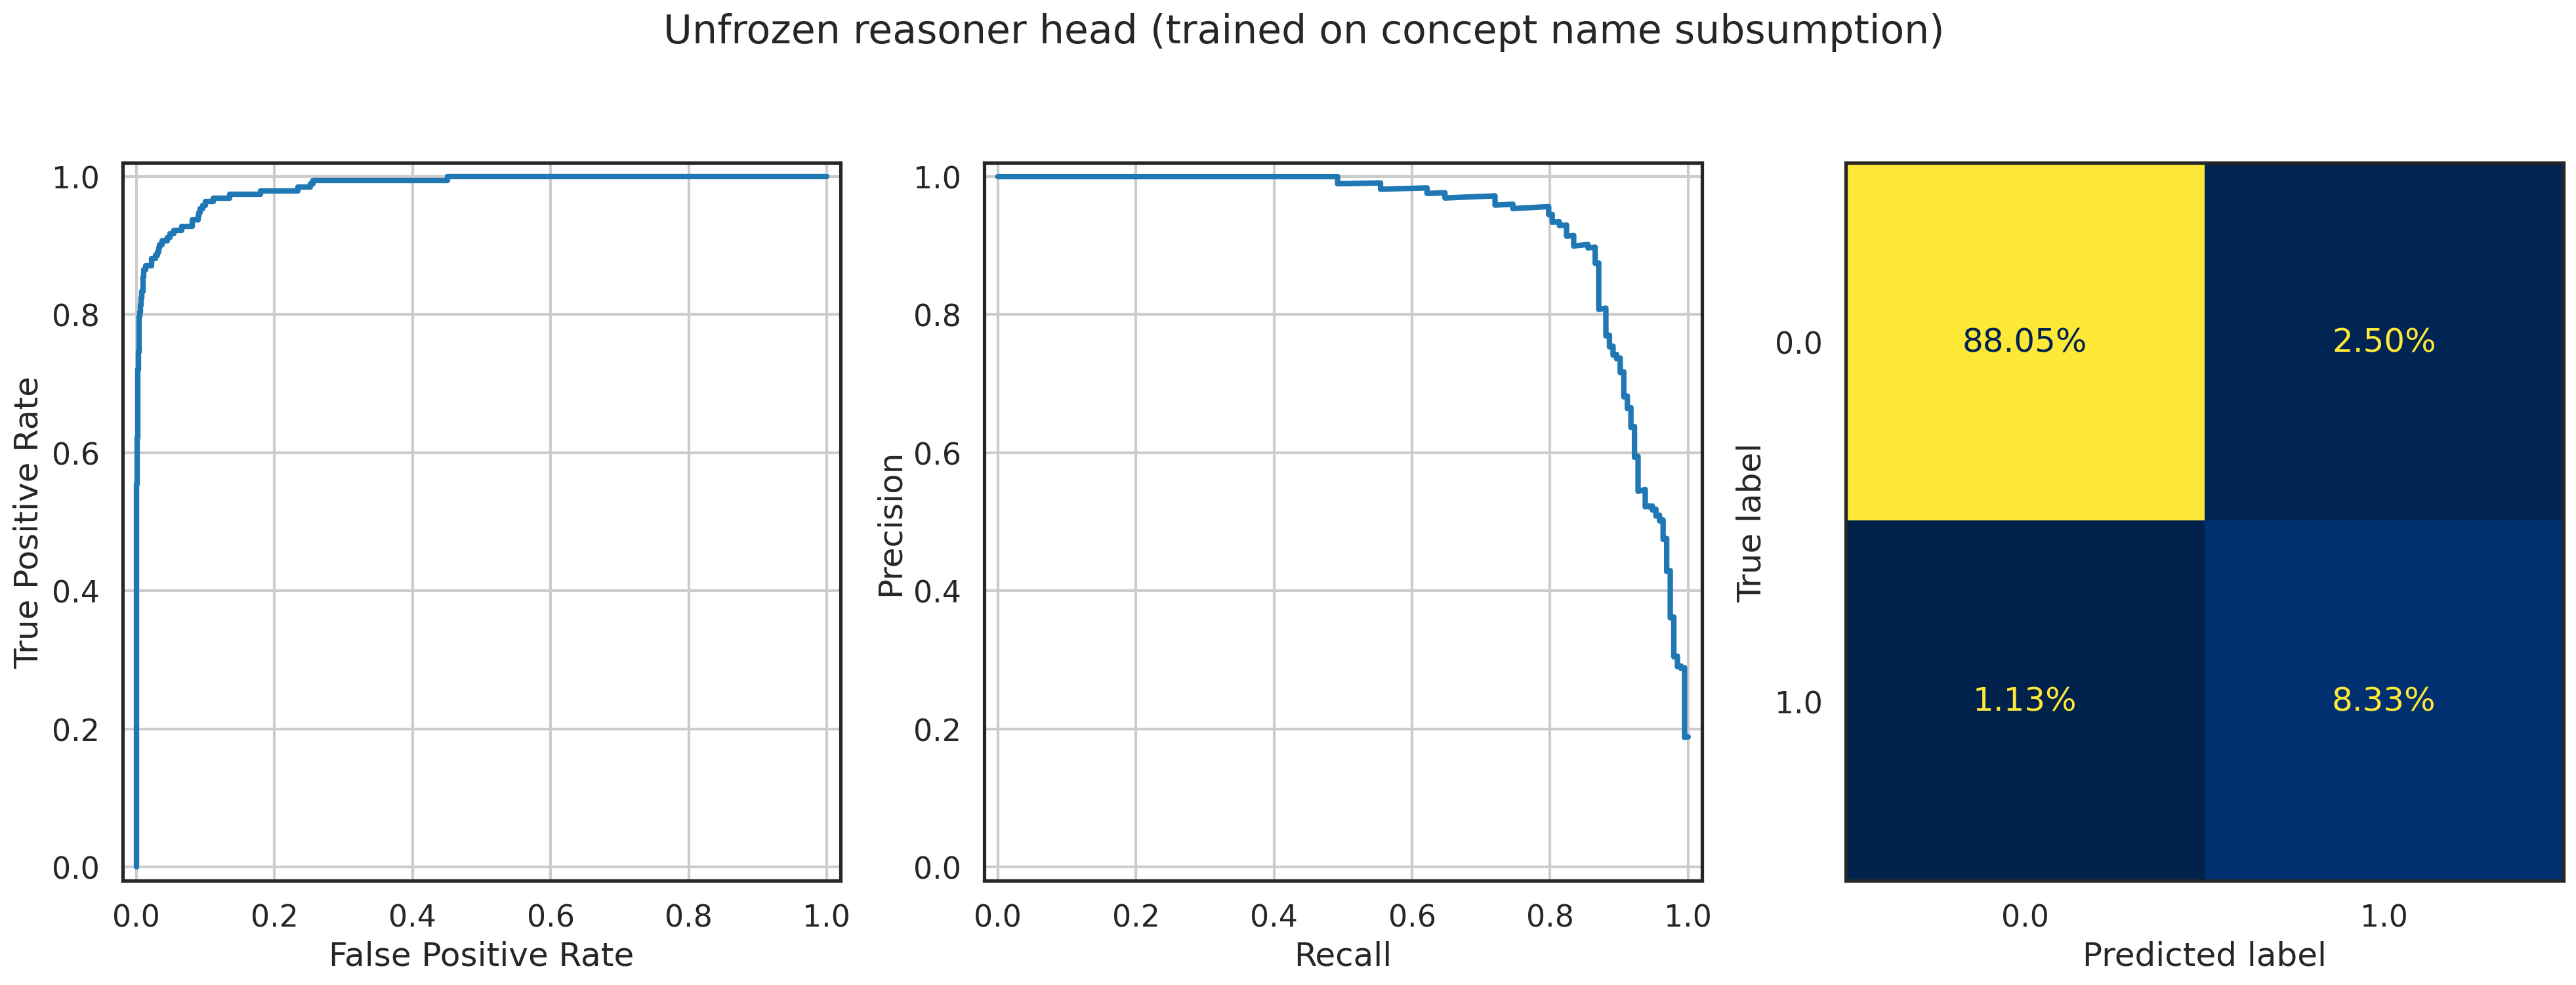

In [8]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [9]:
from random import random

In [10]:
def all_identities(reasoner, encoders, frozen):
    and_nn = reasoner.and_nn
    bot = reasoner.bot_concept
    top = reasoner.top_concept
    sub_nn =reasoner.sub_nn
    not_nn = reasoner.not_nn

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]
    loss=0
    # # A ⊓ A = A
    # loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    # loss += F.mse_loss(input2, and_nn(im_mod(input2, input2)))
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, input3)))

    # # A ⊓ (B ⊓ C) = (A ⊓ B) ⊓ C 
    # loss += F.mse_loss(and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))), and_nn(im_mod(and_nn(im_mod(input3, input2)), input1)))

    # # A ⊓ B = B ⊓ A
    # loss += F.mse_loss(and_nn(im_mod(input1, input3)), and_nn(im_mod(input3, input1)))
    # loss += F.mse_loss(and_nn(im_mod(input3, input2)), and_nn(im_mod(input2, input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, input1)), and_nn(im_mod(input1, input2)))

    # # ⊥ = A ⊓ ¬A
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input1, not_nn(input1))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input2, not_nn(input2))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input3, not_nn(input3))))

    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input1), input1)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input2), input2)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input3),input3)))

    # A = A ⊓ T
    # loss += F.mse_loss(input1, and_nn(im_mod(input1, top[0])))*2
    # loss += F.mse_loss(input1, and_nn(im_mod(input2, top[0])))*2
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, top[0])))*2

    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input1)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input2)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input3)))*2

    # ⊥ = A ⊓ ⊥
    loss += F.mse_loss(bot[0], and_nn(im_mod(input1, bot[0])))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input2, bot[0])))
    loss += F.mse_loss(bot[0], and_nn(im_mod(input3, bot[0])))

    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input1)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input2)))
    loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input3)))

    if not frozen:
        loss += F.mse_loss(bot[0], and_nn(im_mod(top[0], bot[0])))

    #  A ⊑ T -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, top[0])))).sum()
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], top[0])))).sum()

    #  ⊥ ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input3)))).sum()

    #  A ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, input3)))).sum()

    #  ⊥ = ¬T  
    if not frozen:
        loss += F.l1_loss(bot[0], not_nn(top[0]))
    #  T = ¬⊥
        loss += F.l1_loss(top[0], not_nn(bot[0]))

    #  A = ¬(¬(A))
    loss += F.mse_loss(input1, not_nn(not_nn(input1)))
    loss += F.mse_loss(input2, not_nn(not_nn(input2)))
    loss += F.mse_loss(input3, not_nn(not_nn(input3)))
    if not frozen:
        loss += F.l1_loss(T.matmul(not_nn.weight, not_nn.weight), T.eye(not_nn.weight.shape[1])) * 13
    
    #  ⊥ ⊑ ⊥ -> True
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], bot[0])))).sum()

    return loss


all_identities(reasoner.head ,[reasoner.embs], False)

tensor(1.6200, grad_fn=<AddBackward0>)

In [11]:
from random import random

input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.l1_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([ 0.1168,  0.0514,  0.1120, -0.3206, -0.4355, -0.4705,  0.1630, -0.3723,
        -0.1534, -0.3611], grad_fn=<SelectBackward0>)
tensor([-0.0282, -0.0286,  0.1188, -0.1678,  0.1330, -0.1152,  0.0064,  0.0693,
        -0.0167, -0.0664], grad_fn=<AddBackward0>)


tensor(0.2338, grad_fn=<L1LossBackward0>)

In [12]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([ 0.4311, -0.4446,  0.4352,  0.3020,  0.4575, -0.2721, -0.6478,  0.1322,
         0.7908, -0.4280], grad_fn=<SelectBackward0>)
tensor([ 0.0196,  0.0574,  0.0324, -0.1119, -0.0820,  0.0268,  0.0297,  0.2394,
         0.0067, -0.2954], grad_fn=<AddBackward0>)


tensor(0.4270, grad_fn=<L1LossBackward0>)


In [13]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.3273, 0.5818, 0.0194, 0.8494, 0.3162, 0.6748, 0.4223, 0.4084, 0.2705,
        0.1507])
tensor([ 0.0168, -0.2464,  0.2388,  0.1799, -0.2763,  0.1120, -0.1877, -0.0948,
        -0.0557,  0.3228], grad_fn=<AddBackward0>)
tensor(0.4794, grad_fn=<L1LossBackward0>)


In [14]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.4311, -0.4446,  0.4352,  0.3020,  0.4575, -0.2721, -0.6478,  0.1322,
         0.7908, -0.4280], grad_fn=<SelectBackward0>)
tensor([ 0.0383,  0.0377,  0.1292, -0.1506,  0.1955, -0.0419,  0.0257, -0.0106,
         0.0944, -0.0849], grad_fn=<AddBackward0>)
tensor(0.3186, grad_fn=<L1LossBackward0>)


In [15]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([ 0.4311, -0.4446,  0.4352,  0.3020,  0.4575, -0.2721, -0.6478,  0.1322,
         0.7908, -0.4280], grad_fn=<SelectBackward0>)
tensor([ 0.4315, -0.4448,  0.4346,  0.3019,  0.4581, -0.2721, -0.6496,  0.1331,
         0.7911, -0.4280], grad_fn=<SqueezeBackward3>)
tensor(5.0055e-07, grad_fn=<MseLossBackward0>)


In [16]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([-0.3933, -0.0350,  0.1858,  0.0178,  0.2662,  0.2394,  0.6028, -0.0870,
        -0.9749,  0.8258], grad_fn=<SelectBackward0>)
tensor([-0.3947, -0.0349,  0.1857,  0.0184,  0.2654,  0.2385,  0.6031, -0.0869,
        -0.9753,  0.8267], grad_fn=<SqueezeBackward3>)
tensor(5.0576e-07, grad_fn=<MseLossBackward0>)


In [17]:
input1 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
input2 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.and_nn(im_mod(input2,input1)))
print(reasoner.head.and_nn(im_mod(input1,input2)))

F.mse_loss(reasoner.head.and_nn(im_mod(input2,input1)) , reasoner.head.and_nn(im_mod(input1,input2)))

tensor([ 0.0253, -0.0188,  0.0834, -0.1137,  0.0131,  0.0173, -0.0486,  0.0263,
        -0.0580, -0.0679], grad_fn=<AddBackward0>)
tensor([-0.1156, -0.0125,  0.0937, -0.1039,  0.1165, -0.0599,  0.0111,  0.0163,
        -0.0577, -0.0678], grad_fn=<AddBackward0>)


tensor(0.0040, grad_fn=<MseLossBackward0>)

In [18]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te_2))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te_2[błędne_predykcje],
    'Predykcja': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

    Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0        2                 1.0   0.003556          0         77         41
1       13                 0.0   0.997401          0         70         59
2       18                 1.0   0.010288          0         98         96
3       55                 0.0   0.666006          0         54         48
4       60                 0.0   0.935663          0         66         90
..     ...                 ...        ...        ...        ...        ...
78    1985                 1.0   0.675016          0         27         97
79    1986                 0.0   0.907515          0         52         94
80    1992                 0.0   0.586116          0          7         51
81    2008                 0.0   0.973001          0         84         28
82    2009                 0.0   0.777799          0         55         42

[83 rows x 6 columns]


In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0        2                 1.0  3.555569e-03          0         77         41
1       13                 0.0  9.974011e-01          0         70         59
2       18                 1.0  1.028775e-02          0         98         96
3       55                 0.0  6.660057e-01          0         54         48
4       60                 0.0  9.356628e-01          0         66         90
5       89                 1.0  1.721787e-06          0         29         40
6      116                 1.0  1.873938e-01          0         17         48
7      124                 0.0  9.998910e-01          0          3         10
8      133                 1.0  1.045705e-02          0          1         41
9      223                 1.0  6.803754e-01          0          0         11
10     339                 1.0  4.425677e-03          0          5         81
11     349                 0.0  3.982179e-01          0         

In [20]:

print(T.round( T.matmul( reasoner.head.not_nn.weight,reasoner.head.not_nn.weight) *100)/100)

tensor([[1., -0., -0., 0., -0., 0., -0., 0., -0., -0.],
        [-0., 1., 0., 0., -0., -0., 0., -0., -0., -0.],
        [0., 0., 1., 0., 0., -0., 0., -0., 0., -0.],
        [0., 0., -0., 1., 0., 0., 0., 0., -0., 0.],
        [-0., -0., 0., -0., 1., -0., -0., -0., 0., -0.],
        [0., 0., 0., 0., -0., 1., -0., -0., -0., -0.],
        [0., -0., -0., 0., 0., 0., 1., -0., -0., 0.],
        [0., 0., -0., 0., -0., -0., -0., 1., 0., -0.],
        [0., -0., -0., 0., 0., -0., -0., -0., 1., -0.],
        [-0., 0., 0., 0., -0., 0., 0., -0., -0., 1.]], grad_fn=<DivBackward0>)
